#### China Scrappage Program Notebook
Author: Aaron Yu  
Last Modified June 27, 2019

# Table of Contents
1. [Objective/Research Question](#Objective/Research-Question)
1. [Setup](#Setup)
    1. [Packages](#Packages)
    1. [Input Data](#Input-Data)

# Objective/Research Question
In recent years, China has worked to reduce air pollution from motor vehicles by progressively tightening its emissions standards for new vehicles. In lieu of a study conducted in 2011 by China's Ministry of Environmental Protection (MEP) which showed that despite the fact that what are known as yellow-label vehicles, vehicles with yellow environmental labels to their windshields, only account for 16% of China's fleet, they account for 87% of the Particulate Matter (PM) emmited from all vehicles nationwide, China has also implemented an ambitious large-scale vehicle scrappage program to accelerate the retirement of older vehicles. We are refining our emission inventory model inputs for China to more accurately reflect the emissions and fleet impacts of China's scrappage program. In this workbook, we estimate the shape of the survival curves that best represent actual historical vehicle retirement patterns in China over the past decade. We estimate specific survival curves by vehicle type and vehicle emission standard.

# Setup
To find incomplete tasks, search for [todo].  
Read in new sales data without rounding error

## Packages


In [15]:
# Load standard packages
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.widgets import Slider, Button, RadioButtons

# Load custom packages
'''
from common.common import *
from common import emissions_calc
'''

# Settings
pd.options.mode.chained_assignment = None

## Input Data
We are using three sets of data to estimate our survival curves for each vehicle type and emmission standard in China. The first data set is a breakdown of China's fleet in 2016 by vehicle type, size, fuel and emmision standard. The second data set is a table of new vehicle sales by vehicle type and years, from 1985-2017. The third dataset is an implementation timeline for China's new vehicle standards, from China 0 (Uncontrolled) to China 6.

Chinva Vehicle Stock in 2016, sorted by vehicle type and standard

In [16]:
targetStock = pd.read_excel("inputs/China-stock-by-vehicle-and-standard-2016.xls")
keep = ['vehicle','fuel', 'China 0', 'China 1', 'China 2', 'China 3', 'China 4', 'China 5']
targetStock = targetStock.loc[:,keep]
targetStock = pd.melt(targetStock, id_vars = ['vehicle','fuel'], var_name = 'Standard', value_name = 'Stock')
targetStock = targetStock.groupby(by = ['vehicle', 'Standard','fuel'])['Stock'].sum().reset_index()
targetStock.head()

,vehicle,Standard,fuel,Stock
0,Bus,China 0,diesel,5222.333333
1,Bus,China 0,gasoline,48494.500000
2,Bus,China 0,others,53.666667
3,Bus,China 1,diesel,17996.333333
4,Bus,China 1,gasoline,39225.166667


Sales data from 1985 to 2017

In [17]:
salesData = pd.read_excel("inputs/China-new-vehicle-sales.xlsx",skiprows=1)
#Sales Data is measured in units of 1000s
salesData['NewSales'] = salesData['NewSales']*1000 #Converts sales data from thousands to units
# This analysis focuses on Diesel and Gasoline vehicles
salesData = salesData.loc[salesData.Fuel.isin(['Diesel', 'Gasoline'])]
#TODO: Use dictionary and create a new variable to convert Vehicle type to VehCat in NewStd Timeline
vtypeTovcat = {"Bus":"HDV","HDT":"HDV","LCV":"LDV","PC":"LDV","MDT":"HDV", "MC":"MC"}
salesData['VehCat'] = salesData['Vehicle']
salesData['VehCat'].replace(vtypeTovcat,inplace=True)
salesData.head()

,Vehicle,Fuel,Year,NewSales,VehCat
0,Bus,Diesel,1985,2618.515640,HDV
1,Bus,Diesel,1986,20063.988973,HDV
2,Bus,Diesel,1987,29194.133420,HDV
3,Bus,Diesel,1988,24613.156271,HDV
4,Bus,Diesel,1989,41558.347660,HDV


Let's look at China's in-use fleet in 2016 by vehicle type and emission standard. Let's start with HDT.  
[todo] Pie chart of HDT by emission standard.

{'China 2': 7634.0, 'China 3': 151409.5}


<IPython.core.display.Javascript object>


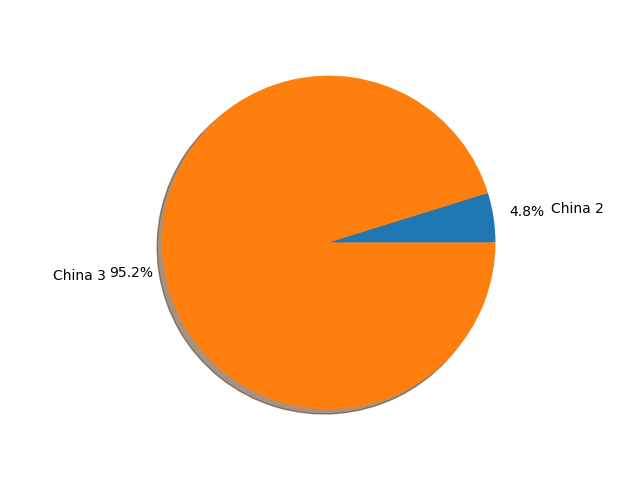

In [21]:
hdtData = targetStock.loc[6:11]
hdtData = hdtData.set_index('Standard')["Stock"].to_dict()

print(hdtData)
labels = hdtData.keys()
sizes = hdtData.values()
plt.close()
plt.pie(sizes, labels = labels,autopct='%1.1f%%', shadow=True,pctdistance=1.2,labeldistance=1.35)
plt.axis('equal')
plt.show()

Let's look at China's new vehicle sales over time by vehicle type. 

[todo] Line chart for vehicle sales
Lets first look at buses as an example


<IPython.core.display.Javascript object>


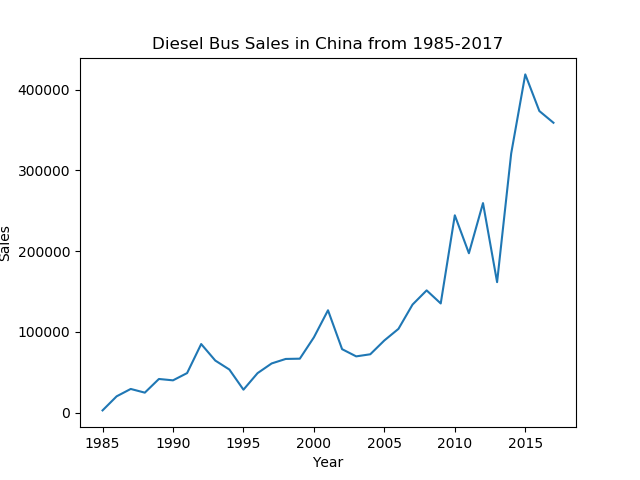

In [22]:
busSalesData = salesData.loc[0:32]
busSalesData= busSalesData.set_index('Year')["NewSales"].to_dict()
plt.close()
plt.plot(busSalesData.keys(),busSalesData.values())
plt.xlabel("Year")
plt.ylabel("Sales")
plt.title("Diesel Bus Sales in China from 1985-2017")
plt.show()

Timeline of Emission Standards

In [23]:
standardsData = pd.read_excel("inputs/Model-inputs-global-2019.xlsx",sheet_name="NewStd",usecols="A:F")
standardsData = standardsData.loc[(standardsData.ISO=='CHN') & (standardsData.Scenario=='Baseline')]
standardsData.rename(columns={"MY":"Year"},inplace=True)
standardsData.head()


,ISO,Fuel,VehCat,Year,NewVehCtrl,Scenario
208,CHN,Diesel,HDV,1970,China 0,Baseline
209,CHN,Diesel,HDV,2001,China 1,Baseline
210,CHN,Diesel,HDV,2004,China 2,Baseline
211,CHN,Diesel,HDV,2008,China 3,Baseline
212,CHN,Diesel,HDV,2013,China 4,Baseline


# Calculations

In [24]:
mergedSalesData = pd.merge(salesData, standardsData, how="left", on=["VehCat","Fuel", "Year"])
mergedSalesData.sort_index(inplace=True)
#todo Group by vehicle type and fuel type and use transform to ensure ffill doesn't spill into next group
mergedSalesData["ISO"].fillna("CHN",inplace=True)
groupvars = ['Vehicle', 'Fuel']
mergedSalesData["Scenario"].fillna("Baseline",inplace=True)
mergedSalesData["NewVehCtrl"] = mergedSalesData.groupby(groupvars)["NewVehCtrl"].transform(lambda x: x.fillna(method="ffill"))
mergedSalesData["NewVehCtrl"].fillna("China 0",inplace=True)
print(mergedSalesData)

    Vehicle      Fuel  Year      NewSales VehCat  ISO NewVehCtrl  Scenario
0       Bus    Diesel  1985  2.618516e+03    HDV  CHN    China 0  Baseline
1       Bus    Diesel  1986  2.006399e+04    HDV  CHN    China 0  Baseline
2       Bus    Diesel  1987  2.919413e+04    HDV  CHN    China 0  Baseline
3       Bus    Diesel  1988  2.461316e+04    HDV  CHN    China 0  Baseline
4       Bus    Diesel  1989  4.155835e+04    HDV  CHN    China 0  Baseline
5       Bus    Diesel  1990  3.987047e+04    HDV  CHN    China 0  Baseline
6       Bus    Diesel  1991  4.885140e+04    HDV  CHN    China 0  Baseline
7       Bus    Diesel  1992  8.485064e+04    HDV  CHN    China 0  Baseline
8       Bus    Diesel  1993  6.439338e+04    HDV  CHN    China 0  Baseline
9       Bus    Diesel  1994  5.326021e+04    HDV  CHN    China 0  Baseline
10      Bus    Diesel  1995  2.828388e+04    HDV  CHN    China 0  Baseline
11      Bus    Diesel  1996  4.877189e+04    HDV  CHN    China 0  Baseline
12      Bus    Diesel  19

In [25]:
mergedSalesData.to_csv("outputs/mergedsalesdata.csv")

# Survival Curve
We define survival curves using the following functional form:  
[todo] write down equation in latex  
$$SR_{i,m} = exp(-(\frac{t}{T_{i,m}})^{k_{i,m}})$$

In [26]:
def survcurve(t, Tm = 15.505, Km = 4):
    
    '''Generate a point on a survival curve.
    
    Parameters
    ----------
    t : int (required)
        vehicle age in years.
    Tm : int (optional)
        approximation of the average vehicle retirement age
    Km : int (optional)
        characteristic parameter that defines the steepness of the curve
        
    Returns
    _______
    float : percent of vehicles surviving at age t
    '''
    return round(np.exp(-(t/Tm)**Km),4)

# Passenger Vehicles

## China 0 Passenger Car Survival Curve
China 0 for passenger cars was implemented in 1970, China 1 was implemented in 2000, so we will only be looking at cars sold between 1970 and 2000
The scrappage targeting China 0 Passenger Cars lasted from 2009 to 2010.  
This means the earliest vehicle age to be scrapped is 2009-2000 = 9 years and the latest is 2010-1970 = 40 years.


In [27]:
def extractData(vehicle, standard,fuel):
    data = mergedSalesData.loc[mergedSalesData["Vehicle"]==vehicle]
    data = data.loc[data["NewVehCtrl"] == standard]
    data = data.loc[data["Fuel"]==fuel]
    return data
pcChina0Dieseldata = extractData("PC","China 0","Diesel")
pcChina0Dieseldata


,Vehicle,Fuel,Year,NewSales,VehCat,ISO,NewVehCtrl,Scenario
296,PC,Diesel,1985,79.132028,LDV,CHN,China 0,Baseline
297,PC,Diesel,1986,902.776922,LDV,CHN,China 0,Baseline
298,PC,Diesel,1987,422.960836,LDV,CHN,China 0,Baseline
299,PC,Diesel,1988,456.335366,LDV,CHN,China 0,Baseline
300,PC,Diesel,1989,503.575739,LDV,CHN,China 0,Baseline
301,PC,Diesel,1990,575.861312,LDV,CHN,China 0,Baseline
302,PC,Diesel,1991,932.504965,LDV,CHN,China 0,Baseline
303,PC,Diesel,1992,1357.795497,LDV,CHN,China 0,Baseline
304,PC,Diesel,1993,1848.205182,LDV,CHN,China 0,Baseline
305,PC,Diesel,1994,2104.832685,LDV,CHN,China 0,Baseline


In [36]:
#generic survival curve, 
def survcurve(t, Tm = 5.10, Km = 26.40):
    Tm = 5.10
    Km=26.50
    t = 2016-t
    '''Generate a point on a survival curve.
    
    Parameters
    ----------
    t : int (required)
        vehicle age in years.
    Tm : int (optional)
        approximation of the average vehicle retirement age
    Km : int (optional)
        characteristic parameter that defines the steepness of the curve
        
    Returns
    _______
    float : percent of vehicles surviving at age t
    '''
    return round(np.exp(-(t/Tm)**Km),4)

In [37]:
salesDataSurvivalCurve = extractData("PC","China 4", "Gasoline")
salesDataSurvivalCurve["Percent Surviving"] = salesDataSurvivalCurve["Year"].apply(survcurve)

salesDataSurvivalCurve.head()

,Vehicle,Fuel,Year,NewSales,VehCat,ISO,NewVehCtrl,Scenario,Percent Surviving
349,PC,Gasoline,2011,1.130850e+07,LDV,CHN,China 4,Baseline,0.5534
350,PC,Gasoline,2012,1.534217e+07,LDV,CHN,China 4,Baseline,0.9984
351,PC,Gasoline,2013,1.776536e+07,LDV,CHN,China 4,Baseline,1.0000
352,PC,Gasoline,2014,1.980440e+07,LDV,CHN,China 4,Baseline,1.0000
353,PC,Gasoline,2015,2.101180e+07,LDV,CHN,China 4,Baseline,1.0000


<IPython.core.display.Javascript object>


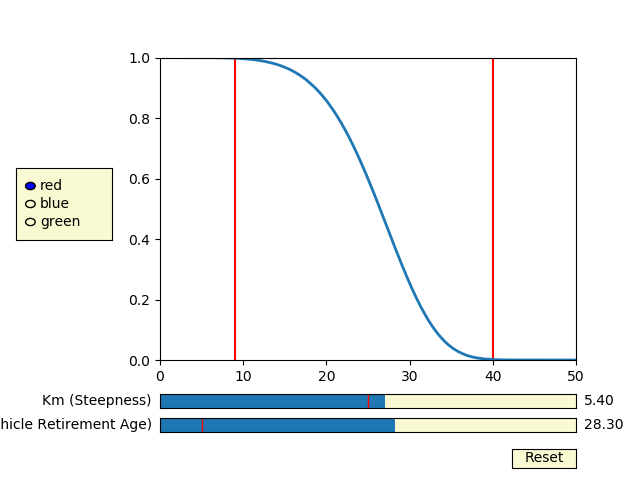

In [10]:
#apply survival curve to sales data
plt.close()
#Returns percentage accuracy
def checkAccuracy(vehicle,standard,fuel,tm,km):
    TotalVehicles = 0
    data = extractData(vehicle,standard,fuel)
    for index, row in data.iterrows():
        year = int(row['Year'])
        sales = int(row['NewSales'])
        TotalVehicles += survcurve((2016-year),tm,km)*sales
    print("Estimate:" + str(TotalVehicles))
    actual = targetStock.loc[targetStock['vehicle']==vehicle]
    actual = actual.loc[actual["Standard"] == standard]
    actual = actual.loc[actual["fuel"] == fuel.lower()]
    actual = int(actual["Stock"])
    print("Actual:" + str(actual))
                             


fig, ax = plt.subplots()
plt.subplots_adjust(left=0.25, bottom=0.25)
t = [i/20 for i in range(1000)]
s = [survcurve(i) for i in t]
plt.axvline(x=9,color='red')
plt.axvline(x=40,color='red')
l, = plt.plot(t, s, lw=2)
plt.axis([0, 50, 0, 1])

axcolor = 'lightgoldenrodyellow'
axTm = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)
axKm = plt.axes([0.25, 0.15, 0.65, 0.03], facecolor=axcolor)

Tm = Slider(axTm, 'Tm (Average Vehicle Retirement Age)', 0, 50, valinit=5, valstep=.1)
Km = Slider(axKm, 'Km (Steepness)', 0, 10, valinit=5, valstep = .1)


def update(val):
    global t
    Tmval = Tm.val
    Kmval = Km.val
    l.set_ydata([survcurve(i,Tmval,Kmval) for i in t])
    print(checkAccuracy("PC","China 0","Diesel",Tmval,Kmval))
    fig.canvas.draw_idle()

Tm.on_changed(update)
Km.on_changed(update)

resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')


def reset(event):
    Tm.reset()
    Km.reset()
button.on_clicked(reset)

rax = plt.axes([0.025, 0.5, 0.15, 0.15], facecolor=axcolor)
radio = RadioButtons(rax, ('red', 'blue', 'green'), active=0)


def colorfunc(label):
    l.set_color(label)
    fig.canvas.draw_idle()
radio.on_clicked(colorfunc)

#Add scrappage value lines

plt.show()

In [ ]:
#compare estimated stock with actual stock